In [1]:
###kaggle kernel 
###This is based on our official notebook - not something I can take credit for :) 
###https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb
###Original Notebook by Jesus Martinez Manso and Benjamin Goldenberg
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [8]:
PLANET_KAGGLE_ROOT = os.path.abspath("data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [118]:
def get_label_list(labels_df):
    """
    Build list with unique labels
    input: training dataframe
    output: label list
    """
    label_list = []
    for tag_str in labels_df.tags.values:
        labels = tag_str.split(' ')
        for label in labels:
            if label not in label_list:
                label_list.append(label)
    return label_list

def add_onehot(label_df):
    """add onehot features for every label"""
    ll = get_label_list(labels_df)
    for label in ll:
        labels_df[label] = label_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    return label_df

def make_cooccurence_matrix(labels_df, labels):
    """
    input: training dataframe, label list
    output: cooccurence_matrix
    draw cooccurence_matrix
    """
    numeric_df = labels_df[labels]
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
def sample_images(labels_df, tags, n=None):
    """
    Randomly sample n images with the specified tags.
    input: tag dataframe and list of tags
    """
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
    
def load_image(filename):
    """Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)"""
    
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    print("Load failed: could not find image {}".format(filename))

def sample_to_fname(sample_df, row_idx, suffix='tif'):
    """
    Given a dataframe of sampled images, get the corresponding filename.
    """
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

def plot_bgrn_histo(image, suffix='tif'):
    """
    given the image array, plot hist of each channel
    """
    if suffix == 'tif':
        bgrn_image = image
        b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]
        t = ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta'))
    else:
        rgb_image = image
        r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
        t = ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'))
    for slice_, name, color in t:
        plt.hist(slice_.ravel(), bins=100, range=[0, bgrn_image.max()], label=name, color=color, histtype='step')
    plt.legend()
    
def plot_bands(image, suffix='tif'):
    """
    given the image array, draw images of each channel
    """
    fig = plt.figure(figsize=(12, 4))
    if suffix == 'tif':
        bgrn_image = image
        b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]
        t = ((r,'red'),(g, 'green'),(b, 'blue'), (nir, 'nir'))
    else:
        rgb_image = image
        r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
        t = ((r,'red'),(g, 'green'),(b, 'blue'))
    for i, (x, title) in enumerate(t):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(title)
        plt.imshow(x)
    
def get_rgb_image(bgrn_image):
    bgr_image = bgrn_image[:,:,:3]
    rgb_image = bgr_image[:, :, [2,1,0]]
    return rgb_image
    
def get_reference():
    jpg_list = os.listdir(PLANET_KAGGLE_JPEG_DIR)[:20000]
    np.random.shuffle(jpg_list)
    jpg_list = jpg_list[:100]
    ref_colors = [[],[],[]]
    for _file in jpg_list:
        _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, _file))[:,:,:3]
        # Flatten 2-D to 1-D
        _data = _img.reshape((-1, 3))
        # Dump pixel values to aggregation buckets
        for i in range(3):
            ref_colors[i] = ref_colors[i] + _data[:, i].tolist()
    ref_colors = np.array(ref_colors)
    ref_means = [np.mean(ref_colors[i]) for i in range(3)]
    ref_stds = [np.std(ref_colors[i]) for i in range(3)]

    for i,color in enumerate(['r','g','b']):
        plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
    plt.legend()
    plt.title('Reference color histograms')
    return ref_means, ref_stds

def calibrate_image(rgb_image, ref_means, ref_stds):
    """
    given a uncalibrated image and ref means and ref stds,
    output a calibrated image
    """
    calibrated_img = rgb_image.copy().astype('float32')
    for i in range(3):
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)
    return calibrated_img.astype('uint8')

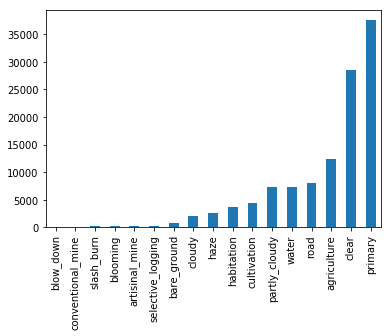

In [38]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
ll = get_label_list(labels_df)
labels_df = add_onehot(labels_df)
labels_df[ll].sum().sort_values().plot.bar()

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


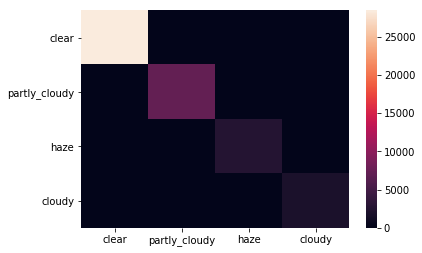

In [41]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(labels_df, weather_labels)

Found image /Users/yao/Google Drive/planet/data/train-jpg/train_26832.jpg


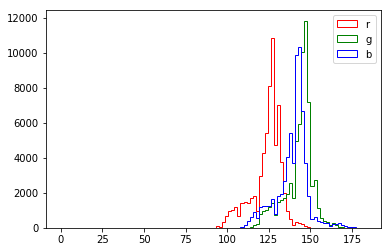

In [103]:
s = sample_images(labels_df, ['primary', 'water','road'], n=1)
fname = sample_to_fname(s, 0, suffix='jpg')
bgrn_image = load_image('train_26832.jpg')
plot_bgrn_histo(bgrn_image, suffix='jpg')

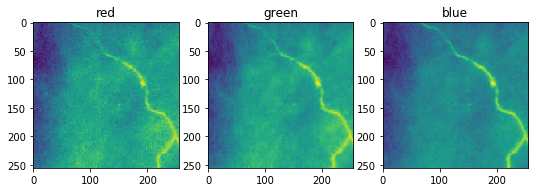

In [106]:
plot_bands(bgrn_image, suffix='jpg')

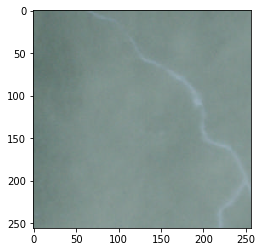

In [110]:
plt.imshow(get_rgb_image(bgrn_image))

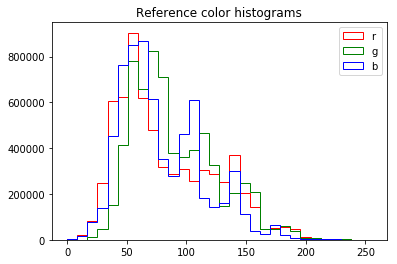

In [119]:
ref_means, ref_stds = get_reference()